In [328]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras import layers
import keras_tuner

#LSTM batch normalization


In [329]:
df = pd.read_csv('Monte_Carlo_10000/training_data_bending.csv')

In [330]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = df[['max_force']].values

In [331]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [332]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mse')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/1000
5/5 [==============================] - 0s 16ms/step - loss: 914.9051 - val_loss: 843.6373
Epoch 2/1000
5/5 [==============================] - 0s 4ms/step - loss: 789.5614 - val_loss: 614.5073
Epoch 3/1000
5/5 [==============================] - 0s 5ms/step - loss: 426.1304 - val_loss: 78.8574
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 102.9212 - val_loss: 124.9914
Epoch 5/1000
5/5 [==============================] - 0s 4ms/step - loss: 61.3265 - val_loss: 35.2254
Epoch 6/1000
5/5 [==============================] - 0s 4ms/step - loss: 62.9819 - val_loss: 61.0205
Epoch 7/1000
5/5 [==============================] - 0s 4ms/step - loss: 37.6330 - val_loss: 7.0646
Epoch 8/1000
5/5 [==============================] - 0s 5ms/step - loss: 25.3145 - val_loss: 18.6828
Epoch 9/1000
5/5 [==============================] - 0s 4ms/step - loss: 19.0965 - val_loss: 11.1765
Epoch 10/1000
5/5 [==============================] - 0s 4ms/step - loss: 19.2678 - val_loss: 

In [333]:
Y_predicted_ANN = model.predict(X_val)

1/1 [==============================] - 0s 38ms/step


In [334]:
mape_ANN = mean_absolute_percentage_error(Y_val, Y_predicted_ANN)
print("MAPE, for ANN:", format(round(mape_ANN, 4)*100,'.2f'), "%")

MAPE, for ANN: 0.62 %


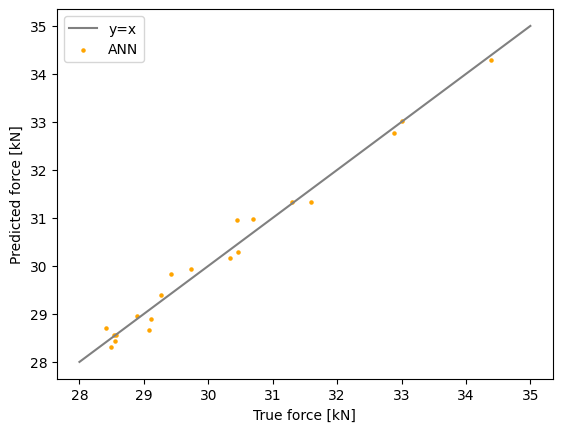

In [335]:
plt.plot([28,35], [28, 35], label='y=x', color='gray')

plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()